![title](yelp2.jpg)
# Smash the Snorkel Team Project: 
# A Weak Supervised Learning Study for Yelp Restaruant Review Classification 


## 1. Introduction

For restuarants receiving numerous reviews, it is hard for the business owners to investigate every review to figure out whether the reviews contain useful suggestions/complaints so that they can know where to improve. Therefore, in this project we seek to automize the classification of reviews to understand whether a review is mentioning complaints or suggestions.  

One challenge that lies ahead is that we don't have datapoints with the label indicating this information to train our classifier. Consequently, to cope with this problem we utilise Snorkel DryBell to automatically label the large number of datapoints and form our training dataset for the classifier. 

In the following parts, we will demonstrate the complete pipeline from loading large size of data from different data sources to automatically labeling the unlabeled data and ultimately train a machine learning model to classify reviews into complaints/suggestions and anything else. 

## 2. Loading Data

In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#from sparknlp import DocumentAssembler
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.embeddings import *
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.common import RegexRule

# Start Spark Session with Spark NLP
spark = sparknlp.start()
print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

ModuleNotFoundError: No module named 'sparknlp'

In [2]:
#Imports
import sys

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import array_contains
from pyspark.ml import Pipeline, PipelineModel

from pyspark.sql import functions as F
from pyspark.sql import SQLContext
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

### 2.1 Data Source 1: Mongo DB

[To be continue:]

### 2.2 Data Source 2: Local JOSN Files

[To be continue:]

### 2.3 Data Filtering

[To be continue:]

In [3]:
#First:  restaurant
biz_df = sqlContext.read.json("original_data/business.json") # Mongo Needed
biz_df.createOrReplaceTempView('biz_table')
#only keep restaurants
biz_res = sqlContext.sql('SELECT * FROM biz_table WHERE categories LIKE \'%Restaurants%\'') # Mongo Needed
biz_res.createOrReplaceTempView('biz_res_table')

def filter_res(parent,filename,key): #filter the irrelevant records from other table
    df = sqlContext.read.json("original_data/"+filename)
    table_name=filename[:-5]+'_table'
    df.createOrReplaceTempView(filename[:-5]+'_table')
    sqlquery = 'SELECT c.* FROM {} c LEFT JOIN {} b ON c.{} = b.{} WHERE b.{} IS NOT NULL'.format(table_name,parent,key,key,key)
    print(sqlquery)
    df_res=sqlContext.sql(sqlquery)
    return df_res

checkin_res = filter_res('biz_res_table','checkin.json','business_id')
review_res = filter_res('biz_res_table','review.json','business_id')
review_res.createOrReplaceTempView('review_res_table')
tip_res = filter_res('review_res_table','tip.json','user_id') #since tip is on individual level, match them with users
user_res = filter_res('review_res_table','user.json','user_id')

SELECT c.* FROM checkin_table c LEFT JOIN biz_res_table b ON c.business_id = b.business_id WHERE b.business_id IS NOT NULL
SELECT c.* FROM review_table c LEFT JOIN biz_res_table b ON c.business_id = b.business_id WHERE b.business_id IS NOT NULL
SELECT c.* FROM tip_table c LEFT JOIN review_res_table b ON c.user_id = b.user_id WHERE b.user_id IS NOT NULL
SELECT c.* FROM user_table c LEFT JOIN review_res_table b ON c.user_id = b.user_id WHERE b.user_id IS NOT NULL


As we focus our classification task on the reviews for the restaurant, here we first filter the 'business' table to 
keep only the restaurants and based on this table we filter out the records in other table that is irrelevent to restarurants.


### 2.4 Data Spliting

[To be continue:]

In [4]:
#sample business into traning_set dev_set and test_set
import pyspark.sql.functions as f
review_res = review_res.withColumn('index_1', f.monotonically_increasing_id())
review_res.createOrReplaceTempView('review_res_table')
sqlquery = 'SELECT * FROM review_res_table ORDER BY RAND(42) LIMIT {}'.format(1000)
review_sample = sqlContext.sql(sqlquery)
review_sample.createOrReplaceTempView('review_sample_table')

sqlquery = 'SELECT a.* FROM review_res_table a LEFT JOIN review_sample_table b ON a.index_1 = b.index_1 WHERE b.index_1 IS NULL '
review_train_all = sqlContext.sql(sqlquery)

#sample 500 into dev_set and 500 into test_set
from pyspark.sql.functions import desc
review_sample = review_sample.withColumn('index_2', f.monotonically_increasing_id())
review_dev = review_sample.limit(500)
review_test = review_sample.sort(desc("index_2")).limit(500)

In [5]:
# sampling from original training_set since it is too large for our single machine to apply the LFs
review_train_all.createOrReplaceTempView('review_train_all_table')
sqlquery = 'SELECT * FROM review_train_all_table ORDER BY RAND(42) LIMIT {}'.format(2500)
review_train = sqlContext.sql(sqlquery)

In [6]:
#review_dev.toPandas().to_csv('filtered_data/review_dev.csv',header = 'true') #tospark
#review_test.toPandas().to_csv('filtered_data/review_test.csv',header = 'true') #tospark

Preparing for the development of labeling fuctions and the training of classifier, we split the filtered review data
into three parts, namely training set, testing set and development set. We first randomly sample 1000 reviews out of all
resturant reviews, and split the first 500 into development set and the rest into testing set. As we don't have labels at all,
we will manually label the reviews in development and testing sets with 1 standing for suggestions/complaints and 0 for the rest.

In addition, considering the computing resources we have it is not feasible for us to apply the labeling functions to all of the remaining
6 million reviews. As a result, we sample 2500 reviews out of the "complete" training set focusing on demonstrating how the whole process may work 
when more computing resources are available.

In [7]:
# I'm just import the .csv for now

df_dev = spark.read.csv("/project/review_dev_labelled.csv", escape='"', multiLine=True,
     inferSchema=True, header=True)

df_dev = df_dev.withColumnRenamed("label\r", "label")
df_dev.show()

+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+
|  #|         business_id|cool|            date|funny|           review_id|stars|                text|useful|             user_id|      index_1|index_2|label|
+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+
|  0|XFhnPpO2x0nS-lVkq...|   1|14/02/2017 16:50|    0|o6VZ0cQEfIBvGW15u...|    2|I knew it was a k...|     0|dk5yqirSwDH7Cpp52...|1080000000000|      0|  1.0|
|  1|SRCepG6PbMvwKcfIU...|   0|11/12/2015 02:47|    0|PBy3gB_D1xEiBJDrw...|    2|Average place, bu...|     0|xmtWxX67wF7afssQR...| 730000000000|      1|  1.0|
|  2|pneBBrIzd3SCbbglY...|   2|15/05/2015 19:18|    0|AeyK7AEtbfubw1aD0...|    4|This is a great o...|     4|X4k8ugJaihHVLHq32...| 490000000000|      2|  0.0|
|  3|8enR8Wc0ot9L41JY1...|   0|15/09/2017 13:1

## 3. Labeling Functions

### 3.1 Manual Labeling


Our goal is to train a classifier over the Yelp data that could predict whether a comment/text is positive (containing suggestions or complaints) or negative. Hence, we have access to a large amount of unlabelled data in the form of Yelp comments with some metadata. After filtered the dataset, we split the filtered review data into training set, testing set and development set. Because originally the dataset doesn't contain any labels, our members manually labelled the reviews in development and testing sets (500 labels for each) with "1" for positive and "0" for negative. Therefore, the result of our label model can be tested in a reasonable way later.



### 3.2 Writing Labeling Functions 


In this case, we used labelling functions (LFs) in Snorkel to apply the weak supervision approach by using programmatic rules and heuristics that assign labels to unlabelled training data. Individuals all have different methods to express their understanding and opinions, therefore, there is very unlikely exist completely same comments. Otherwise, if a single LF had high enough coverage to label our entire test dataset accurately, we don't need a classifier at all. In reality, most problems are not that simple. Instead, we usually need to combine multiple LFs to label our dataset, to improve the overall accuracy of the training labels we generate by factoring in multiple different signals, like keywords extraction, heuristics and numerical method.

### 3.2.1 SparkNLP (Simon's Preprocessing)

In [19]:
from snorkel.labeling import LabelingFunction

In [20]:
#Try to apply Labeling function
import pyspark.sql.functions as F
from snorkel.labeling import LabelModel
from snorkel.labeling.apply.spark import SparkLFApplier
import pandas as pd
import numpy as np
#from snorkel.labeling import ,LFAnalysis
from snorkel.labeling import LFAnalysis
from pyspark.sql import Row
from snorkel.labeling.lf import labeling_function
#from snorkel.labeling.lf.nlp_spark import spark_nlp_labeling_function
from snorkel.preprocess import preprocessor

ABSTAIN = -1
NEGATIVE = 0
POSITIVE = 1

** SIMON sparkNLP brief intro **

We used the development split to come up with labelling functions which are rules and heuristics that assign labels to unlabelled training data.
<br>
<br>
Before we develop our LFs we followed a standard NLP pre-processing pipeline and then an analysis on the text of reviews.<br>
<br>
The first step is to transform the raw data into a Document type that will be used by annotators further in the pipeline. For this task we used the DocumentAssembler(). The next step is to tokenize and normalize the text.<br>
<br>
Tokenization: is the process of splitting a text or a string into a list of tokens. We used tokenization to split the review into individual words and remove any noise such as punctuation.<br>
<br>
Remove stopwords: We removed all the stopwords from the reviews as they cause unnecessary noise without providing any useful information. Stopwords are commonly used words such as: the, an, a etc.<br>
<br>
Lemmatization: Is the process of transforming inflected words to their common root. Inflected words are words that are modified to express grammatical categories such as voice and tense. For example play--> played. In NLP lemmatization is useful to group words with the same meaning so they can be analysed as a single item. This reduces the amount of text to be processed.
<br> 
<br> ++++SENTIMENT FROM SPARKNLP <br>
<br>


In [8]:
### create clean tokens check with pipeline. 
#DO NOT worry about document_assembler , sentence_detector and finisher in the end 
#(are preprocessors of the preprocessors :P)
#The pipeline has the following steps: tokenizer -->normalizer -->lemmatizer -->stop_words_cleaner

document_assembler = DocumentAssembler() \
            .setInputCol("text")\
            .setOutputCol("document")\
            .setCleanupMode("shrink")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token") \
    #.setSplitChars(['-']) \
   # .setContextChars(['(', ')', '?', '!']) \

normalizer = Normalizer() \
            .setInputCols(["token"]) \
            .setLowercase(True)\
            .setOutputCol("normal")

lemmatizer = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["normal"]) \
    .setOutputCol("lemma") \
    #.setDictionary("/tmp/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")

stop_words_cleaner = StopWordsCleaner() \
        .setInputCols(["lemma"]) \
        .setOutputCol("cleanTokens") \
        .setCaseSensitive(False) 

finisher = Finisher() \
    .setInputCols(["cleanTokens"]) \
    .setIncludeMetadata(False)\
    .setOutputCols(["cleanTokens"])

pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    normalizer,
    lemmatizer,
    stop_words_cleaner,
    finisher
])

normalized_data = pipeline.fit(df_dev).transform(df_dev)
normalized_data.show(5)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+
|  #|         business_id|cool|            date|funny|           review_id|stars|                text|useful|             user_id|      index_1|index_2|label|         cleanTokens|
+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+
|  0|XFhnPpO2x0nS-lVkq...|   1|14/02/2017 16:50|    0|o6VZ0cQEfIBvGW15u...|    2|I knew it was a k...|     0|dk5yqirSwDH7Cpp52...|1080000000000|      0|  1.0|[know, kitschy, p...|
|  1|SRCepG6PbMvwKcfIU...|   0|11/12/2015 02:47|    0|PBy3gB_D1xEiBJDrw...|    2|Average place, bu...|     0|xmtWxX67wF7afssQR...| 730000000000|      1|  1.0|[average, place, ...|
|

In [9]:
#here we convert the cleantokens from a list to a string line (juct in case we need it later)
from pyspark.sql.functions import concat_ws

normalized_data = normalized_data.withColumn("cleanTokens_n", concat_ws(",", "cleanTokens"))
normalized_data.select('cleanTokens_n').show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cleanTokens_n                                                                                                                                                                                                                                                                                                                                                                            

In [10]:
#Get Number of Tokens (number of meaningful words)
normalized_data = normalized_data.withColumn('n_clean_tokens', F.expr('size(cleanTokens)'))
normalized_data.show(5)

+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+
|  #|         business_id|cool|            date|funny|           review_id|stars|                text|useful|             user_id|      index_1|index_2|label|         cleanTokens|       cleanTokens_n|n_clean_tokens|
+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+
|  0|XFhnPpO2x0nS-lVkq...|   1|14/02/2017 16:50|    0|o6VZ0cQEfIBvGW15u...|    2|I knew it was a k...|     0|dk5yqirSwDH7Cpp52...|1080000000000|      0|  1.0|[know, kitschy, p...|know,kitschy,plac...|            65|
|  1|SRCepG6PbMvwKcfIU...|   0|11/12/2015 02:47|    0|PBy3gB_D1xEiBJDrw...|    2|Average place, bu...|     0|xmtWxX67wF7afssQR...| 73000

In [11]:
#Sentiment per review
####### ATTENTION
#### I CALCULATE TWO DIFFERENT SENTIMENT COLUMNS WITH ANOTHER APPROACH THAN SHUO (shuo's are still in the end)
#### WE NEED TO DECIDE WHICH OF ALL THESE (Two mine and one from shuo) we want to keep

#Sentiment Feature 1 - pipeline
## A general label (positive or negative for all the review)
document_assembler = DocumentAssembler() \
    .setInputCol("text")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

lemmatizer = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \
        
sentiment_detector = SentimentDetector() \
    .setInputCols(["lemma", "sentence"]) \
    .setOutputCol("sentiment_score") \
    .setDictionary("./sentiment_lexicon.txt", ",")  #Chen, Y., & Skiena, S. (2014). Building Sentiment Lexicons for All Major Languages. In ACL (2) (pp. 383-389).
    
finisher = Finisher() \
    .setInputCols(["sentiment_score"]) \
    .setOutputCols(["lex_sentiment"])


pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer, 
    lemmatizer, 
    sentiment_detector, 
    finisher
    ])
normalized_data = pipeline.fit(normalized_data).transform(normalized_data)
normalized_data.show()

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+-------------+
|  #|         business_id|cool|            date|funny|           review_id|stars|                text|useful|             user_id|      index_1|index_2|label|         cleanTokens|       cleanTokens_n|n_clean_tokens|lex_sentiment|
+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+-------------+
|  0|XFhnPpO2x0nS-lVkq...|   1|14/02/2017 16:50|    0|o6VZ0cQEfIBvGW15u...|    2|I knew it was a k...|     0|dk5yqirSwDH7Cpp52...|1080000000000|      0|  1.0|[know, kitschy, p...|know,kitschy,plac...|           

In [12]:
#Sentiment Feature 2 - pipeline
#Get Sentiment ratio from the sum of all sentences for each review 
#E.g. how many positive sentences we have out of all and vice versa

pipeline = PretrainedPipeline("analyze_sentiment", lang="en") #is a pretrained pipeline; we do not need to define steps
sentiment_data = pipeline.annotate(normalized_data, column='text')

from pyspark.sql import functions as F
sentiment_data = sentiment_data.withColumn('pos_cnt', F.expr('size(filter(sentiment.result, x -> x in ("positive")))'))
sentiment_data = sentiment_data.withColumn('neg_cnt', F.expr('size(filter(sentiment.result, x -> x in ("negative")))'))
sentiment_data = sentiment_data.withColumn("pos_prc", sentiment_data["pos_cnt"]/(sentiment_data["pos_cnt"]+sentiment_data["neg_cnt"])).fillna(0)

sentiment_data.show(5)

analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]
+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+-------+------------------+
|  #|         business_id|cool|            date|funny|           review_id|stars|                text|useful|             user_id|      index_1|index_2|label|         cleanTokens|       cleanTokens_n|n_clean_tokens|lex_sentiment|            document|            sentence|               token|             checked|           sentiment|pos_cnt|neg_cnt|           pos_prc|
+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+-----

In [21]:
from snorkel.labeling import LabelingFunction
#DO NOT CONFUSE POSITIVE SENTIMENT WITH POSITIVE LABEL (Contains complaint or suggestion)

@labeling_function()
def review_false(x):   
    return POSITIVE if x.lex_sentiment[0]=='negative' else ABSTAIN

#DO NOT CONFUSE POSITIVE SENTIMENT WITH POSITIVE LABEL (Contains complaint or suggestion)

@labeling_function()
def positive_percentage(x):
    return POSITIVE if x.pos_prc < 0.3 else ABSTAIN

### 3.2.3 Analysis of normalized review text

After pre-processing, the text is ready to be analysed. We examined whether there are unique keywords that are useful to determine the label that have a sufficiently high coverage.

Unique keywords:<br>
Step 1: Extract the normalized text into a list
<br>
Step 2: Identify the unique words that appear in the reviews of rows that are labelled 1 but not in the reviews of rows that are labelled 0 and vice versa
<br>
Step 3: Find the difference between the two lists


In [56]:
df_dev = sentiment_data
df_dev.show()

+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+-------+-------------------+
|  #|         business_id|cool|            date|funny|           review_id|stars|                text|useful|             user_id|      index_1|index_2|label|         cleanTokens|       cleanTokens_n|n_clean_tokens|lex_sentiment|            document|            sentence|               token|             checked|           sentiment|pos_cnt|neg_cnt|            pos_prc|
+---+--------------------+----+----------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+-------------+--------------------+--------

In [23]:
df_dev_1 = df_dev.filter(df_dev.label==1)

In [24]:
type(df_dev_1)

pyspark.sql.dataframe.DataFrame

In [25]:
df_dev_1 = df_dev.filter(df_dev.label==1)
df_dev_1.select("cleanTokens_n").rdd.flatMap(lambda x: x).collect()

['know,kitschy,place,find,online,picture,online,match,get,eat,locate,park,lot,front,mall,next,motelhotel,typical,look,outside,usual,jukebox,old,poster,assorted,memorabilia,wall,nobody,dress,like,see,one,ad,service,alright,slow,server,table,plus,table,behind,couple,overwhelm,look,like,lot,snowbirds,go,well,hotel,worker,stop,bite,head,food,reasonable,nice,honest,wish,choose,someplace,else,go,wouldnt,return',
 'average,place,wish,wouldve,read,review,order,torta,figure,way,id,never,order,one,ill,give,torta,another,chance',
 'burger,carnival,cruise,ship,couple,year,ago,burger,ship,awesome,eat,everyday,hear,place,vegas,roll,mayor,flavortown,burger,wife,ringer,burger,think,burger,cruise,ship,well,seem,recipe,something,different',
 'read,meme,today,read,take,one,fucking,kid,time,couldnt,fit,perfect,review,order,large,thin,pepperoni,pizza,come,buck,figure,must,large,really,good,pick,get,home,open,box,small,costco,pizza,think,must,fuckin,amazing,nope,pizza,hella,dry,barely,sauce,literally,dip,bb

In [26]:
#Convert the string column to list

df_dev_1 = df_dev.filter(df_dev.label==1)
clean_tokens_label_1= df_dev_1.select("cleanTokens_n").rdd.flatMap(lambda x: x).collect()

df_dev_0 = df_dev.filter(df_dev.label==0)
clean_tokens_label_0= df_dev_0.select("cleanTokens_n").rdd.flatMap(lambda x: x).collect()

# Find the words that appear in the reviews of label=1 but not in label=0
Difference_one_zero=list(set(clean_tokens_label_1) - set(clean_tokens_label_0))
# Find the words that appear in the reviews of label=0 but not in label =1
Difference_zero_one=list(set(clean_tokens_label_0) - set(clean_tokens_label_1))

### 3.2.3 Analysis of normalized review text

Useful Keywords:<br>
During the "gold" labelling phase, we noted down keywords that we thought appear frequently in each of the labels. Then with trial and error we defined different labelling functions based on those keywords and compared their performance by evaluating the coverage-accuracy trade-off. the best performing keywords were chosen and formed into LFs.

the tested keywords are listed below: 


In [27]:
list_label_0=["perfect", "always", "delicious", "enjoy", "amazing","great", "love",
        "excellent", "favourite" , "clean", "impeccable", "fabulous", "fav",
        "generous", "regulars", "outstanding", "regular", "bomb", "authentic",
        "reasonably","gem","amazing","excellent"]
   
list_label_1=["Rude","disappointment", "avoid", "overcooked", "pricey", "worst", "awkward" ,
       "awkwardly" , "expensive", "annoying", "tasteless", "bland", "Gross", "ewww",
       "slow","mess", "rubbery", "needed", "undercoocked", "wrong", "horrific",
       "grease", "horrible","overpriced", "overwhelmed", "dry" ,"tiny",
       "disgusting", "cardboard", "inattentive", "unfortunately",  "chewy" ,
       "unpleasant", "sucked", "displeased", "delayed", "loud", "crappy", "alright"]

We grouped by the label and calculated statistics that could be useful for the development stage

In [29]:
# !!!! TO PAVLOS: ALL THE ORIGINAL AGG METRICS HAVE BEEN COMBINED IN A SINGLE ROW
from pyspark.sql.functions import count, avg

results_agg = df_dev.groupby("label").agg(avg("funny"), avg("useful"), avg("cool"), avg("n_clean_tokens"), count('label'))
results_agg.show()

+-----+-------------------+------------------+-------------------+-------------------+------------+
|label|         avg(funny)|       avg(useful)|          avg(cool)|avg(n_clean_tokens)|count(label)|
+-----+-------------------+------------------+-------------------+-------------------+------------+
|  0.0|0.25874125874125875|0.8391608391608392|0.46153846153846156|  46.61188811188811|         286|
|  1.0| 0.6915887850467289|1.5467289719626167| 0.7336448598130841|  68.67757009345794|         214|
+-----+-------------------+------------------+-------------------+-------------------+------------+



In [31]:
#Pavlos's Part:
@labeling_function()
def short_comment(x):
    """Negative comments are often short, such as 'foods were insane'"""
    return NEGATIVE if len(x.text.split()) < 20 else ABSTAIN

@labeling_function()
def Keyword_perfect(x):
    """Perfect is a keyword that frequently appeared in reviews with negative label'"""
    return NEGATIVE if "perfect" in x.text.lower() else ABSTAIN

@labeling_function()
def long_comments(x):
    """Positive comments are often long, complaints are usually detailed.'"""
    return POSITIVE if len(x.text.split()) > 350 else ABSTAIN

@labeling_function()
def keyword_bad(x):
    """Bad is a keyword that frequently appears in reviews with positive label'"""
    return POSITIVE if "bad" in x.text.lower() else ABSTAIN




### 3.2.3 Shuo's LFs

<div class="alert alert-success">
<b> Keywords Labeling Functions </b>

<p>For text/comment in the dataset, some Labeling Functions(LFs later in this paper) could be written based on just keywords lookups. 
    These will often follow a realtive similar execution pattern, so we can create a template and use the resources parameter to pass
    in specific keywords. Between, same for the labeling_function decorator, the LabelingFunction class wraps 
    a Python function (the f parameter), and we can use the resources parameter to pass in keyword arguments (here, our keywords to 
    lookup) to said function.
</div>


In [32]:
from snorkel.labeling import LabelingFunction

def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN
def make_keyword_lf(keywords, label=0):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label)
    )
"""NEGATIVE comments talk about 'I love pizza', 'Love this resturant', etc."""
keyword_love = make_keyword_lf(keywords=["love"])

"""NEGATIVE comments talk about 'This food is perfect', 'Perfect people' to describe."""
keyword_perfect = make_keyword_lf(keywords=["perfect"])

"""POSITIVE comments talk about 'The waiter is rude', 'Their behaviour is rude', etc."""
keyword_rude = make_keyword_lf(keywords=["rude"])

"NEGATIVE comments talk about 'I love pizza', 'Love this resturant', etc."

"NEGATIVE comments talk about 'This food is perfect', 'Perfect people' to describe."

"POSITIVE comments talk about 'The waiter is rude', 'Their behaviour is rude', etc."

In [33]:
@labeling_function()
def keyword_less(x):
    return POSITIVE if re.search("less", x.text, flags=re.I) else ABSTAIN
@labeling_function()
def keyword_love(x):
    return NEGATIVE if re.search("love", x.text, flags=re.I) else ABSTAIN
@labeling_function()
def keyword_great(x):
    return NEGATIVE if re.search("great", x.text, flags=re.I) else ABSTAIN
@labeling_function()
def keyword_rude(x):
    return POSITIVE if re.search("rude", x.text, flags=re.I) else ABSTAIN

<div class="alert alert-success">
<b> Heuristic Keywords Labeling Functions </b>

<p>When I manually labelled the development dataset at the very beginning stage,  
    I realise the POSITIVE text always come up with high useful rate and vice versa.
    Meanwhile, funny rate could 
    equal to 0, if this comment is labelled as 0. Hence, certain LFs were made.
</div>

In [34]:
@labeling_function()
def high_useful(x):
    return POSITIVE if x.useful > 10 else ABSTAIN
@labeling_function()
def low_useful(x):
    return NEGATIVE if x.useful < 2 else ABSTAIN
@labeling_function()
def funny(x):
    return NEGATIVE if x.funny == 0 else ABSTAIN

<div class="alert alert-success">
<b> Summary --> DEPRECATED (Goes after Pavlos' LFs) </b>

<p>Overall, the coverage, accuracy and relationship among LFs made above can be obtained from below Label Metrics.

</div>

### 3.2.4 Pavlos's LFs

In [35]:
import re

In [36]:
from snorkel.labeling import LabelingFunction


@labeling_function()
def short_comment(x):
    """Negative comments are often short, such as 'foods were insane'"""
    return NEGATIVE if x.n_clean_tokens < 20 else ABSTAIN


@labeling_function()
def keyword_disgusting(x):
    """Negative comments are often short, such as 'foods were insane'"""
    return POSITIVE if "disgusting" in x.text.lower() else ABSTAIN

@labeling_function()
def keyword_cardboard(x):
    """Negative comments are often short, such as 'foods were insane'"""
    return POSITIVE if "cardboard" in x.text.lower() else ABSTAIN

@labeling_function()
def regex_home(x):
    return POSITIVE if re.search(r"home.*about", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def regex_regular(x):
    return NEGATIVE if re.search(r"regular*", x.text, flags=re.I) else ABSTAIN
@labeling_function()
def regex_recomend(x):
    return POSITIVE if re.search(r"not.recommend*", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def Keyword_gem(x):
    return NEGATIVE if "gem" in x.text.lower() else ABSTAIN

@labeling_function()
def Keyword_perfect(x):
    return NEGATIVE if "perfect" in x.text.lower() else ABSTAIN

@labeling_function()
def Keyword_avoid(x):
    return POSITIVE if "avoid" in x.text.lower() else ABSTAIN

@labeling_function()
def regex_over_coocked(x):
    return POSITIVE if re.search(r"over.cooked*", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def Keyword_overpriced(x):
    return POSITIVE if "overpriced" in x.text.lower() else ABSTAIN

@labeling_function()
def long_comments(x):
    """Negative comments are often short, such as 'foods were insane'"""
    return POSITIVE if len(x.text.split()) > 350 else ABSTAIN

@labeling_function()
def key_good(x):
    """Negative comments are often short, such as 'foods were insane'"""
    return POSITIVE if "bad" in x.text.lower() else ABSTAIN

@labeling_function()
def keyword_bad(x):
    """Bad is a keyword that frequently appears in reviews with positive label'"""
    return POSITIVE if "bad" in x.text.lower() else ABSTAIN




'''@labeling_function()
def sentiment(x):
    """Negative comments are often short, such as 'foods were insane'"""
    return POSITIVE if x.lex_sentiment[0]=='positive' else ABSTAIN
'''

'@labeling_function()\ndef sentiment(x):\n    """Negative comments are often short, such as \'foods were insane\'"""\n    return POSITIVE if x.lex_sentiment[0]==\'positive\' else ABSTAIN\n'

### 3.2 Writing Labeling Functions 2: Numerical Functions

[Shuo part]

After manually labelling, our member realised that customers or visitors normally give a labelled "1" comments after they graded the business as a low grade (1 or 2 Star out of 5). Then, he did numerical study about the star and contribute couple of high coverage LFs to our Label Model.  

In [37]:
#Jiaqi's Part
# aggregate the mean star each business and individual
df_biz_stars=biz_res.select('business_id','stars','review_count') # aggregate business
ind_stars=review_res.select('user_id','stars','business_id') #aggregate ind
mapped_test = ind_stars.rdd.map(lambda x: (x[0],x[1]))
ind_total_starts = mapped_test.reduceByKey(lambda a,b:a+b)
mapped_test = ind_stars.rdd.map(lambda x: (x[0],1))
ind_total_review =  mapped_test.reduceByKey(lambda a,b:a+b)

# convert to spark data frame
df_ind_total_starts = ind_total_starts.toDF(["user_id", "total_stars"])
df_ind_total_review = ind_total_review.toDF(["user_id", "total_reviews"])
df_ind_stars = df_ind_total_starts.join(df_ind_total_review, df_ind_total_starts.user_id == df_ind_total_review.user_id)
df_ind_stars = df_ind_stars.withColumn('avg_stars' , df_ind_stars.total_stars/df_ind_stars.total_reviews)
df_ind_stars.show()
df_biz_stars.show()

+--------------------+-----------+--------------------+-------------+------------------+
|             user_id|total_stars|             user_id|total_reviews|         avg_stars|
+--------------------+-----------+--------------------+-------------+------------------+
|-0Ji0nOyFe-4yo8BK...|        4.0|-0Ji0nOyFe-4yo8BK...|            1|               4.0|
|-1KKYzibGPyUX-Mwk...|        4.0|-1KKYzibGPyUX-Mwk...|            1|               4.0|
|-1zQA2f_syMAdA04P...|       10.0|-1zQA2f_syMAdA04P...|            2|               5.0|
|-2Pb5d2WBPtbyGT_b...|        5.0|-2Pb5d2WBPtbyGT_b...|            1|               5.0|
|-3bsS2i9xqjNnIA1f...|        5.0|-3bsS2i9xqjNnIA1f...|            2|               2.5|
|-3i9bhfvrM3F1wsC9...|       34.0|-3i9bhfvrM3F1wsC9...|            9|3.7777777777777777|
|-47g7LR58tpHlm7Bm...|        5.0|-47g7LR58tpHlm7Bm...|            1|               5.0|
|-4Anvj46CWf57KWI9...|        3.0|-4Anvj46CWf57KWI9...|            1|               3.0|
|-4xyc3OgPwrLshmqH...

In [38]:
#from here we start to use pandas
df_biz_stars=df_biz_stars.toPandas()
df_ind_stars=df_ind_stars.toPandas()
df_ind_stars = df_ind_stars.loc[:,~df_ind_stars.columns.duplicated()]

import pandas as pd
from pyspark.sql import SparkSession
from snorkel.labeling import PandasLFApplier,LFAnalysis
spark = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()
pd_dev = pd.read_csv("review_dev_labelled.csv",header=0, index_col=0)
df_dev = spark.createDataFrame(pd_dev)


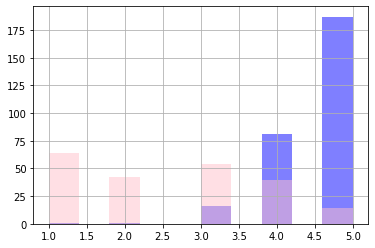

In [39]:
#Threshold Analysis: Pure Stars
temp=pd_dev  
temp[temp['label']==0]['stars'].hist(bins=10,color='blue',alpha=0.5);
temp[temp['label']==1]['stars'].hist(bins=10,color='pink',alpha=0.5);

As shown in the threshold analysis here, it is understood that if reviews have a star lower than 2, it is very likely to
contain complaint/suggestion. And for those whose star is higher than five, it is probably a review without complaints/suggestion. Therefore, we create two labeling functions based on 
this observation.

In [40]:

import pyspark.sql.functions as F
from snorkel.labeling import LabelModel
from snorkel.labeling.apply.spark import SparkLFApplier
import pandas as pd
import numpy as np
from snorkel.labeling import LFAnalysis
from pyspark.sql import Row
from snorkel.labeling.lf import labeling_function
#from snorkel.labeling.lf.nlp_spark import spark_nlp_labeling_function
from snorkel.preprocess import preprocessor

ABSTAIN = -1
NEGATIVE = 0
POSITIVE = 1

@labeling_function()
def low_star(x):
    return POSITIVE if x.stars<=2 else ABSTAIN


@labeling_function()
def high_star(x):
    return NEGATIVE if x.stars==5 else ABSTAIN



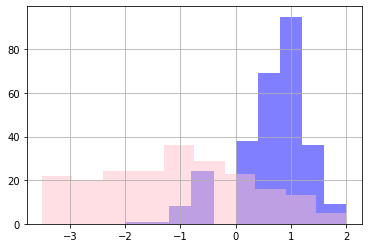

In [41]:
#Threshold Analysis: Higher or lower than business average
temp=pd_dev.merge(df_biz_stars, on= 'business_id', how='left')
temp['dif']= temp['stars_x']-temp['stars_y']
temp[temp['label']==0]['dif'].hist(bins=10,color='blue',alpha=0.5);
temp[temp['label']==1]['dif'].hist(bins=10,color='pink',alpha=0.5);

The graph shows that if the review star is more than one star lower than the business star, then it's very likely 
than the review should be label as 1 whereas if it is higher than the business star, it is probably a review without
complaints or suggestions.

In [42]:
dict_biz_stars = dict(zip(df_biz_stars.business_id, df_biz_stars.stars))

@labeling_function(resources=dict(dict_biz_stars=dict_biz_stars))
def higher_than_biz(x,dict_biz_stars):
    if x.business_id!='#NAME?':
        a = dict_biz_stars[x.business_id]
    else:
        a = 0
    return NEGATIVE if a<x.stars  else ABSTAIN

@labeling_function(resources=dict(dict_biz_stars=dict_biz_stars))
def lower_than_biz(x,dict_biz_stars):
    if x.business_id!='#NAME?':
        a = dict_biz_stars[x.business_id]
    else:
        a = 0
    return POSITIVE if a>x.stars+1  else ABSTAIN

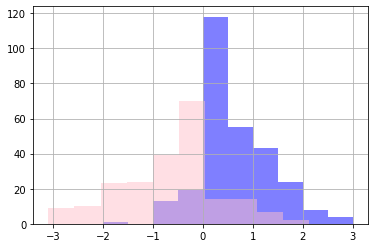

In [43]:
#Threshold Analysis: higher or lower than individual average
temp=pd_dev.merge(df_ind_stars, on= 'user_id', how='left')
temp['dif']= temp['stars']-temp['avg_stars']
temp[temp['label']==0]['dif'].hist(bins=10,color='blue',alpha=0.5);
temp[temp['label']==1]['dif'].hist(bins=10,color='pink',alpha=0.5);

The graph shows that if the review star is lower than the average user star, then it's very likely 
than the review should be label as 1 whereas if it is higher, it is probably a review without
complaints or suggestions.

In [44]:
com_info = zip(df_ind_stars.avg_stars, df_ind_stars.total_reviews)
dict_ind_stars = dict(zip(df_ind_stars.user_id, com_info ))
@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def higher_than_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            a = dict_ind_stars[x.user_id][0]
            b = dict_ind_stars[x.user_id][1]
        else:
            a = 0
            b = 0 
    else:
        a = 0
        b = 0
    return NEGATIVE if (x.stars > a) else ABSTAIN

@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def lower_than_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            a = dict_ind_stars[x.user_id][0]
            b = dict_ind_stars[x.user_id][1]
        else:
            a = 0
            b = 0 
    else:
        a = 0
        b = 0
    return POSITIVE if (x.stars < a) else ABSTAIN

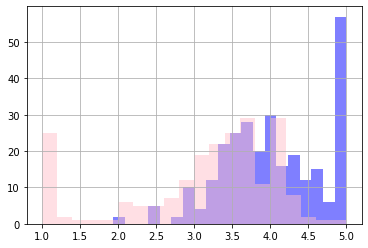

In [45]:
#Threshold Analysis: Picky individual
temp[temp['label']==0]['avg_stars'].hist(bins=20,color='blue',alpha=0.5);
temp[temp['label']==1]['avg_stars'].hist(bins=20,color='pink',alpha=0.5);

The graph shows that if the average review star is lower than 4.25, the review is more likely to be a complaint or suggestion.

In [46]:
@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def picky_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            a = dict_ind_stars[x.user_id][0]
            b = dict_ind_stars[x.user_id][1]
        else:
            a = 0
            b = 0 
    else:
        a = 0
        b = 0
    return POSITIVE if a <4.25 else ABSTAIN

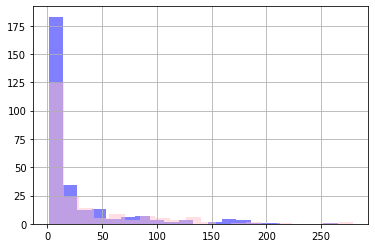

In [47]:
#Threshold Analysis: Talktive individual
temp[(temp['label']==0) & (temp['total_reviews']<300)]['total_reviews'].hist(bins=20,color='blue',alpha=0.5);
temp[(temp['label']==1)& (temp['total_reviews']<300)]['total_reviews'].hist(bins=20,color='pink',alpha=0.5);

In [48]:
@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def talktive_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            b = dict_ind_stars[x.user_id][1]
        else:
            b = 0 
    else:
        b = 0
    return POSITIVE if b > 86  else ABSTAIN

In [49]:
#merge user_dev.jointime 
reduced_user = user_res.select('user_id','yelping_since')
reduced_user_pd= reduced_user.toPandas().drop_duplicates(subset=['user_id'])
reduced_user_pd['date']=reduced_user_pd['yelping_since'].map(lambda x:int(x[0:4]))
temp=pd_dev.merge(reduced_user_pd, on= 'user_id', how='left')

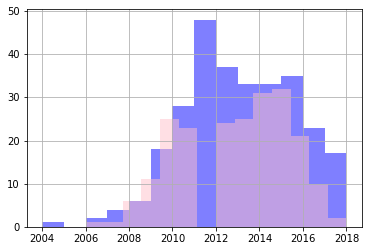

In [50]:
temp[temp['label']==0]['date_y'].hist(bins=14,color='blue',alpha=0.5);
temp[temp['label']==1]['date_y'].hist(bins=14,color='pink',alpha=0.5);

The graph shows that if the join year is 2011 or after 2016, the review is less likely to be a complaint or suggestion.

In [51]:
dict_user_date = dict(zip(reduced_user_pd.user_id, reduced_user_pd.date))
@labeling_function(resources=dict(dict_user_date=dict_user_date))
def date_ind(x,dict_user_date):
    if x.user_id!='#NAME?':
        if x.user_id in dict_user_date.keys():
            b = dict_user_date[x.user_id]
        else:
            b = 3000 
    else:
        b = 3000
    return NEGATIVE if (b==2011 or b>=2016)  else ABSTAIN

### 3.3.3 Wrap-up of all LFs

In [52]:
#Try to apply Labeling function
import pyspark.sql.functions as F
from snorkel.labeling import LabelModel
from snorkel.labeling.apply.spark import SparkLFApplier
import pandas as pd
import numpy as np
#from snorkel.labeling import ,LFAnalysis
from snorkel.labeling import LFAnalysis
from pyspark.sql import Row
from snorkel.labeling.lf import labeling_function
#from snorkel.labeling.lf.nlp_spark import spark_nlp_labeling_function
from snorkel.preprocess import preprocessor

ABSTAIN = -1
NEGATIVE = 0
POSITIVE = 1

In [57]:
lfs = [
    #simon
    positive_percentage, review_false,
    #shuo
    keyword_love,keyword_great,keyword_rude,keyword_less,low_useful,high_useful, funny,
    #pavlos all 
    short_comment,long_comments,keyword_disgusting,keyword_cardboard,regex_home,
    Keyword_perfect,Keyword_avoid,keyword_bad,regex_over_coocked, Keyword_overpriced,key_good,
    #jiaqhi
    low_star,high_star,higher_than_biz,lower_than_biz,higher_than_ind,lower_than_ind,
    picky_ind,talktive_ind,date_ind
    ]
applier = SparkLFApplier(lfs)
L_dev = applier.apply(df_dev.rdd)
g_label =np.array(df_dev.select('label').collect())
LFAnalysis(L_dev, lfs).lf_summary(g_label)




,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
positive_percentage,0,[1],0.164,0.164,0.160,51,31,0.621951
review_false,1,[1],0.110,0.110,0.106,48,7,0.872727
keyword_love,2,[0],0.194,0.194,0.144,72,25,0.742268
keyword_great,3,[0],0.342,0.342,0.276,109,62,0.637427
keyword_rude,4,[1],0.032,0.032,0.030,14,2,0.875000
keyword_less,5,[1],0.084,0.084,0.084,29,13,0.690476
low_useful,6,[0],0.772,0.772,0.618,232,154,0.601036
high_useful,7,[1],0.010,0.010,0.008,4,1,0.800000
funny,8,[0],0.802,0.802,0.648,241,160,0.600998
short_comment,9,[0],0.200,0.200,0.140,73,27,0.730000


## 4. Data Augmentation

In [ ]:
#pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
#pip install utils-py
# import nltk
# from nltk.corpus import wordnet as wn
# from snorkel.augmentation import transformation_function
# import spacy
# from snorkel.preprocess.nlp import SpacyPreprocessor
# import en_core_web_sm
# spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)
# from snorkel.augmentation import RandomPolicy
# nltk.download("wordnet")

 After we label the training set programmatically using LFs through Snorkel, we aim to augment the labelled training set using transformation functions (TFs). The aim of augmentation is to increase the size of the labelled training set by creating transformed copies of original data points. The transformation is class-preserving and is dictated by the user-defined TFs.

## 4.1: Define Transformation Functions

TFs are functions that make minor alterations to the original data and create valid new data points of the original class.
In our dataset, we use text as one of the main sources of information for labelling. Therefore, we use the transformation_function decorator from Snorkel to define TFs that will return a slightly modified version of the original text. If the TFs cannot be applied to a datapoint the function returns nothing.
The transformation_function decorator takes an argument pre for pre-processor. We specify a SpacyPeprossessor for the augmentation task.
We defined four TFs that are listed below:

We replace verbs, nouns and adjectives with a synonym <br>
1.)	replace_verb_with_synonym:<br>
2.)	replace_noun_with_synonym<br>
3.)	replace_adjective_with_synonym<br>
<br>
we change the position of adjectives in the text.<br>
4.)	swap_adjectives:


In [ ]:
#Define TFs

def get_synonym(word, pos=None):
    """Get synonym for word given its part-of-speech (pos)."""
    synsets = wn.synsets(word, pos=pos)
    # Return None if wordnet has no synsets (synonym sets) for this word and pos.
    if synsets:
        words = [lemma.name() for lemma in synsets[0].lemmas()]
        if words[0].lower() != word.lower():  # Skip if synonym is same as word.
            # Multi word synonyms in wordnet use '_' as a separator e.g. reckon_with. Replace it with space.
            return words[0].replace("_", " ")
        
def replace_token(spacy_doc, idx, replacement):
    """Replace token in position idx with replacement."""
    return " ".join([spacy_doc[:idx].text, replacement, spacy_doc[1 + idx :].text])

@transformation_function(pre=[spacy])
def replace_verb_with_synonym(x):
    # Get indices of verb tokens in sentence.
    verb_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "VERB"]
    if verb_idxs:
        # Pick random verb idx to replace.
        idx = np.random.choice(verb_idxs)
        synonym = get_synonym(x.doc[idx].text, pos="v")
        # If there's a valid verb synonym, replace it. Otherwise, return None.
        if synonym:
            x.text = replace_token(x.doc, idx, synonym)
            return x
        
@transformation_function(pre=[spacy])
def replace_noun_with_synonym(x):
    # Get indices of noun tokens in sentence.
    noun_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "NOUN"]
    if noun_idxs:
        # Pick random noun idx to replace.
        idx = np.random.choice(noun_idxs)
        synonym = get_synonym(x.doc[idx].text, pos="n")
        # If there's a valid noun synonym, replace it. Otherwise, return None.
        if synonym:
            x.text = replace_token(x.doc, idx, synonym)
            return x


@transformation_function(pre=[spacy])
def replace_adjective_with_synonym(x):
    # Get indices of adjective tokens in sentence.
    adjective_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "ADJ"]
    if adjective_idxs:
        # Pick random adjective idx to replace.
        idx = np.random.choice(adjective_idxs)
        synonym = get_synonym(x.doc[idx].text, pos="a")
        # If there's a valid adjective synonym, replace it. Otherwise, return None.
        if synonym:
            x.text = replace_token(x.doc, idx, synonym)
            return x
@transformation_function(pre=[spacy])      
def swap_adjectives(x):
    adjective_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "ADJ"]
    # Check that there are at least two adjectives to swap.
    if len(adjective_idxs) >= 2:
        idx1, idx2 = sorted(np.random.choice(adjective_idxs, 2, replace=False))
        # Swap tokens in positions idx1 and idx2.
        x.text = " ".join(
            [
                x.doc[:idx1].text,
                x.doc[idx2].text,
                x.doc[1 + idx1 : idx2].text,
                x.doc[idx1].text,
                x.doc[1 + idx2 :].text,
            ]
        )
        return x
    
tfs = [replace_verb_with_synonym,
       replace_noun_with_synonym,
       replace_adjective_with_synonym,
       swap_adjectives]

## 4.2 : Apply Transformation Functions

We define a Random Policy that randomly picks the sequence of TFs to be applied on each data point. We define the number of TFs to be applied on each data point to be 2 by setting sequence_length=2 and the number of transformed data points per original point to be 2 by setting n_per_original =2.

In [ ]:
from snorkel.augmentation import RandomPolicy

random_policy = RandomPolicy(
    len(tfs), sequence_length=2, n_per_original=2, keep_original=True
)

In [ ]:
from snorkel.augmentation import PandasTFApplier
tf_applier = PandasTFApplier(tfs,random_policy)

# Apply the TFs on the train set
df_train_augmented = tf_applier.apply(pd_dev)
Y_train_augmented = df_train_augmented["label"].values

print(f"Original training set size: {pd_dev.size}")
print(f"Augmented training set size: {df_train_augmented.size}")


The augmented data frame almost tripled in size. The reason why it has not exactly tripled in size is because sometimes TFs cannot be applied to a data point and hence return nothing.
Now we can use the augmented data to train a model.


## 5. Training the Binary Classifier 

[To be continue:]

## 6. Conclusion

[To be continue:]